### AR作法
＊每年調整產業(類別、比重)，每年調一次  
＊採用過去500天資料  
  
1.首先：那些產業年底還有權重  
2.所有產業價格（指數收盤價）→變動率  
3.先將weight <= 0.15%的拿掉，避免bug  
4.過去500天 乘 個股數，乘權重，dropna  
5.作PCA，降為20%(1/5)個產業，四捨五入  
6.公式
*  Wi = e^(-(i-1)*a)  
*  Mean = ΣWi*Xi / ΣWi  
*  Var = ΣWi*(Xi-Mean) / ΣWi  
*  AR Ratio = ΣVar_pca / ΣVar_raw_data  

7.Z = (MA15 - MA365) / std365  

### 抓資料方式
weight: SPX-MEMB-分類選GICS產業-輸出excel  
價格: DPDF影響個股價格，打勾表示拿掉，要全打勾

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
import datetime as dt
from datetime import datetime
from sklearn.decomposition import PCA

In [28]:
# 匯入資料
sector_price = pd.read_csv("C:\Users\Sascha683\work\data\SystematicCrisis\enhance/industries_complete_NEW.csv", index_col = 0, parse_dates = True)
sector_weight = pd.read_csv("C:\Users\Sascha683\work\data\SystematicCrisis\enhance/weight.csv", index_col = 0, header=None, parse_dates = True)

In [29]:
today=sector_price.index[-1]
for i in range(10):
    sector_price.loc[sector_price.index[-1]+dt.timedelta(days=1)]=sector_price.iloc[-1,:]

In [30]:
sector_price

,S5CBNK,S5SOFT,S5OILG,S5INSSX,S5CMPE,S5ITSV,S5SSEQ,S5PHARX,S5INCR,S5CAPM,...,S5TRIN,S5WIREX,S5SEMI,S5OFFEX,S5DIVFX,S5ITCSX,S5REALX,S5INMS,S5ENTE,SPXT
1990-01-01,77.78,51.12,90.04,NaN,116.30,NaN,28.39,69.93,NaN,NaN,...,NaN,NaN,28.39,NaN,NaN,NaN,NaN,NaN,NaN,379.41
1990-01-02,78.75,52.22,90.40,NaN,120.70,NaN,29.70,70.95,NaN,NaN,...,NaN,NaN,29.70,NaN,NaN,NaN,NaN,NaN,NaN,386.16
1990-01-03,78.82,51.05,89.06,NaN,122.03,NaN,29.49,71.54,NaN,NaN,...,NaN,NaN,29.49,NaN,NaN,NaN,NaN,NaN,NaN,385.17
1990-01-04,78.36,51.00,88.10,NaN,123.23,NaN,29.60,71.13,NaN,NaN,...,NaN,NaN,29.60,NaN,NaN,NaN,NaN,NaN,NaN,382.02
1990-01-05,78.10,49.98,87.19,NaN,122.96,NaN,29.19,70.03,NaN,NaN,...,NaN,NaN,29.19,NaN,NaN,NaN,NaN,NaN,NaN,378.30
1990-01-06,78.10,49.98,87.19,NaN,122.96,NaN,29.19,70.03,NaN,NaN,...,NaN,NaN,29.19,NaN,NaN,NaN,NaN,NaN,NaN,378.30
1990-01-07,78.10,49.98,87.19,NaN,122.96,NaN,29.19,70.03,NaN,NaN,...,NaN,NaN,29.19,NaN,NaN,NaN,NaN,NaN,NaN,378.30
1990-01-08,78.11,50.21,88.07,NaN,123.80,NaN,29.42,70.44,NaN,NaN,...,NaN,NaN,29.42,NaN,NaN,NaN,NaN,NaN,NaN,380.04
1990-01-09,76.60,48.84,87.05,NaN,122.84,NaN,29.88,69.59,NaN,NaN,...,NaN,NaN,29.88,NaN,NaN,NaN,NaN,NaN,NaN,375.56
1990-01-10,75.67,48.00,86.81,NaN,121.85,NaN,29.30,69.33,NaN,NaN,...,NaN,NaN,29.30,NaN,NaN,NaN,NaN,NaN,NaN,373.09


In [31]:
"""
import math
industry_complete=pd.read_csv('C:\Users\Sascha683\work\data\SystematicCrisis\enhance/industries_complete_NEW.csv' ,  index_col=0 ,header= None, encoding = 'utf8', parse_dates = True)
industry_complete.columns=industry_complete.iloc[0,:]
industry_complete=industry_complete.iloc[1:,:]
industry_complete=industry_complete.astype('float')
SPXT_price = industry_complete.pop('SPXT').loc["1998-01-01":]
industry=industry_complete/industry_complete.shift(1)
industry=(industry.iloc[1:,:]-1)*100
industry=industry.loc["1997-11-01":,:]
industry_cov=industry.cov()
#industry_cov=pd.DataFrame(columns=industry.columns)
#for i in range(industry.shape[1]):
#    temp=[]
#    for j in range(industry.shape[1]):
#        temp.append(pd.concat([industry.iloc[:,i],industry.iloc[:,j]],axis=1).dropna().cov().iloc[0,1])
#    industry_cov.loc[industry.columns[i]]=temp
industry_cov_inv = pd.DataFrame(np.linalg.pinv(industry_cov.fillna(0).values), industry_cov.columns, industry_cov.index)
"""

'\nimport math\nindustry_complete=pd.read_csv(\'C:\\Users\\Sascha683\\work\\data\\SystematicCrisis\\enhance/industries_complete_NEW.csv\' ,  index_col=0 ,header= None, encoding = \'utf8\', parse_dates = True)\nindustry_complete.columns=industry_complete.iloc[0,:]\nindustry_complete=industry_complete.iloc[1:,:]\nindustry_complete=industry_complete.astype(\'float\')\nSPXT_price = industry_complete.pop(\'SPXT\').loc["1998-01-01":]\nindustry=industry_complete/industry_complete.shift(1)\nindustry=(industry.iloc[1:,:]-1)*100\nindustry=industry.loc["1997-11-01":,:]\nindustry_cov=industry.cov()\n#industry_cov=pd.DataFrame(columns=industry.columns)\n#for i in range(industry.shape[1]):\n#    temp=[]\n#    for j in range(industry.shape[1]):\n#        temp.append(pd.concat([industry.iloc[:,i],industry.iloc[:,j]],axis=1).dropna().cov().iloc[0,1])\n#    industry_cov.loc[industry.columns[i]]=temp\nindustry_cov_inv = pd.DataFrame(np.linalg.pinv(industry_cov.fillna(0).values), industry_cov.columns, ind

In [32]:
import math
industry_complete=pd.read_csv('C:\Users\Sascha683\work\data\SystematicCrisis\enhance/industries_complete_NEW.csv' ,  index_col=0 ,header= None, encoding = 'utf8', parse_dates = True)
industry_complete.columns=industry_complete.iloc[0,:]
industry_complete=industry_complete.iloc[1:,:]
industry_complete=industry_complete.astype('float')
SPXT_price = industry_complete.pop('SPXT').loc["1998-01-01":]
industry=industry_complete/industry_complete.shift(1)
industry=(industry.iloc[1:,:]-1)*100
for i in range(10):
    industry.loc[industry.index[-1]+dt.timedelta(days=1)]=industry.iloc[-1,:]
    industry_complete.loc[industry_complete.index[-1]+dt.timedelta(days=1)]=industry_complete.iloc[-1,:]
turbulence=[]
#for i in range(len(industry)-181,len(industry)-31):
#for i in range(2859,len(industry)-31):
for i in range(len(industry)-91,len(industry)-31):
    industry_cov=industry.iloc[:i+30,:].cov()
    industry_cov_inv = pd.DataFrame(np.linalg.pinv(industry_cov.fillna(0).values), industry_cov.columns, industry_cov.index)
    industry_temp=industry.iloc[i:i+31,:].dropna(axis=1)
    return_period=(((industry_complete.loc[industry_temp.index[-2]])/(industry_complete.loc[industry_temp.index[0]]))-industry.mean()/100).fillna(0)
    return_period[return_period>10]=0
    return_period=((return_period-1)*100).replace(-100,0)
    turbulence.append(return_period.T.dot(industry_cov_inv.dot(return_period)))
    print i
    print industry_temp.index[-1]
    print return_period.T.dot(industry_cov_inv.dot(return_period))

10595
2019-02-04 00:00:00
1335.9662966
10596
2019-02-05 00:00:00
1427.24545633
10597
2019-02-06 00:00:00
1274.82186004
10598
2019-02-07 00:00:00
1137.63829082
10599
2019-02-08 00:00:00
1273.42523038
10600
2019-02-09 00:00:00
1459.54257159
10601
2019-02-10 00:00:00
1367.93873757
10602
2019-02-11 00:00:00
1365.45957708
10603
2019-02-12 00:00:00
1390.83799868
10604
2019-02-13 00:00:00
1334.79336403
10605
2019-02-14 00:00:00
1280.0816763
10606
2019-02-15 00:00:00
1298.7080266
10607
2019-02-16 00:00:00
1258.59097195
10608
2019-02-17 00:00:00
1089.68090545
10609
2019-02-18 00:00:00
1003.84597196
10610
2019-02-19 00:00:00
1369.97902659
10611
2019-02-20 00:00:00
1246.93223562
10612
2019-02-21 00:00:00
1596.28277971
10613
2019-02-22 00:00:00
1566.08928254
10614
2019-02-23 00:00:00
2143.14199295
10615
2019-02-24 00:00:00
1811.33842205
10616
2019-02-25 00:00:00
1794.97387769
10617
2019-02-26 00:00:00
1912.7150297
10618
2019-02-27 00:00:00
1733.84330904
10619
2019-02-28 00:00:00
1653.96127763
1062

In [33]:
i=2859
industry.iloc[:i+31,:]

NaT,S5CBNK,S5SOFT,S5OILG,S5INSSX,S5CMPE,S5ITSV,S5SSEQ,S5PHARX,S5INCR,S5CAPM,...,S5THMFX,S5TRIN,S5WIREX,S5SEMI,S5OFFEX,S5DIVFX,S5ITCSX,S5REALX,S5INMS,S5ENTE
0,,,,,,,,,,,,,,,,,,,,,
1990-01-02,1.247107,2.151800,0.399822,NaN,3.783319,NaN,4.614301,1.458601,NaN,NaN,...,NaN,NaN,NaN,4.614301,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.088889,-2.240521,-1.482301,NaN,1.101906,NaN,-0.707071,0.831572,NaN,NaN,...,NaN,NaN,NaN,-0.707071,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,-0.583608,-0.097943,-1.077925,NaN,0.983365,NaN,0.373008,-0.573106,NaN,NaN,...,NaN,NaN,NaN,0.373008,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,-0.331802,-2.000000,-1.032917,NaN,-0.219102,NaN,-1.385135,-1.546464,NaN,NaN,...,NaN,NaN,NaN,-1.385135,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-06,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-07,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,0.012804,0.460184,1.009290,NaN,0.683149,NaN,0.787941,0.585463,NaN,NaN,...,NaN,NaN,NaN,0.787941,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-09,-1.933171,-2.728540,-1.158170,NaN,-0.775444,NaN,1.563562,-1.206701,NaN,NaN,...,NaN,NaN,NaN,1.563562,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-10,-1.214099,-1.719902,-0.275704,NaN,-0.805926,NaN,-1.941098,-0.373617,NaN,NaN,...,NaN,NaN,NaN,-1.941098,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
"""
for i in range(10):
    industry.loc[industry.index[-1]+dt.timedelta(days=1)]=industry.iloc[-1,:]
    industry_complete.loc[industry_complete.index[-1]+dt.timedelta(days=1)]=industry_complete.iloc[-1,:]
turbulence=[]
#for i in range(len(industry)-181,len(industry)-31):
for i in range(len(industry)-31):
    industry_temp=industry.iloc[i:i+31,:].dropna(axis=1)
#    turbulence_cov=industry_temp[1:].cov()
#    turbulence_cov_inv = pd.DataFrame(np.linalg.pinv(turbulence_cov.values), turbulence_cov.columns, turbulence_cov.index)
    return_period=(((industry_complete.loc[industry_temp.index[-1]])/(industry_complete.loc[industry_temp.index[0]]))-industry.mean()/100).fillna(0)
    return_period[return_period>10]=0
    return_period=((return_period-1)*100).replace(-100,0)
    turbulence.append(return_period.T.dot(industry_cov_inv.dot(return_period)))
    print i
    print industry_temp.index[-1]
    print return_period.T.dot(industry_cov_inv.dot(return_period))
"""

'\nfor i in range(10):\n    industry.loc[industry.index[-1]+dt.timedelta(days=1)]=industry.iloc[-1,:]\n    industry_complete.loc[industry_complete.index[-1]+dt.timedelta(days=1)]=industry_complete.iloc[-1,:]\nturbulence=[]\n#for i in range(len(industry)-181,len(industry)-31):\nfor i in range(len(industry)-31):\n    industry_temp=industry.iloc[i:i+31,:].dropna(axis=1)\n#    turbulence_cov=industry_temp[1:].cov()\n#    turbulence_cov_inv = pd.DataFrame(np.linalg.pinv(turbulence_cov.values), turbulence_cov.columns, turbulence_cov.index)\n    return_period=(((industry_complete.loc[industry_temp.index[-1]])/(industry_complete.loc[industry_temp.index[0]]))-industry.mean()/100).fillna(0)\n    return_period[return_period>10]=0\n    return_period=((return_period-1)*100).replace(-100,0)\n    turbulence.append(return_period.T.dot(industry_cov_inv.dot(return_period)))\n    print i\n    print industry_temp.index[-1]\n    print return_period.T.dot(industry_cov_inv.dot(return_period))\n'

In [35]:
ma_turbulence=[]
ma_turbulence_sort=[]
for i in range(29,len(turbulence)):
    sum_temp=0.0
    for j in range(30):
        sum_temp += turbulence[i-j]
    ma_turbulence.append(sum_temp/30.0)
    ma_turbulence_sort.append(sum_temp/30.0)
#ma_turbulence=pd.DataFrame(ma_turbulence[2:],index=industry_complete.loc["1998-01-01":].index,columns=["ma_turbulence"])
ma_turbulence=pd.DataFrame(ma_turbulence[1:],index=industry_complete.index[-30:],columns=["ma_turbulence"])
ma_turbulence

,ma_turbulence
0,
2019-03-07,1385.803308
2019-03-08,1367.614337
2019-03-09,1359.298600
2019-03-10,1354.019260
2019-03-11,1337.410191
2019-03-12,1314.599437
2019-03-13,1295.211188
2019-03-14,1280.341090
2019-03-15,1264.172717


In [36]:
# 計算報酬
sector_return = (sector_price / sector_price.shift(1) - 1) * 100
sector_return = sector_return.shift(1)

In [37]:
# 拿掉名稱行，補上日期index
temp_index = list(sector_weight.index)
for i in range(len(temp_index)//3):
    temp_index[i*3+2] = temp_index[i*3]
    
sector_weight.index = temp_index
sector_weight = sector_weight.drop('NaT')

# 小於0.15%則忽略 → 補成NA
for i in range(len(sector_weight.index)//2):
    for j in range(len(sector_weight.columns)):
        if sector_weight.iloc[i*2+1, j] == '--' or None:
            sector_weight.iloc[i*2+1, j] = float('NaN')
        elif float(sector_weight.iloc[i*2+1, j]) <= 0.15:
            sector_weight.iloc[i*2+1, j] = float('NaN')

In [38]:
# 起始日1997-01-01(仰賴自己手動找到index)
sector_return.index[2557]
startdate_index = 2557
#startdate_index = 10100
startdate_index = len(sector_return) - 30
AR_Ratio = pd.DataFrame(index = sector_return.index[startdate_index:], columns = ['AR_Ratio'])

In [39]:
"""
Wi = e^(-(i-1)*a)
Mean = ΣWi*Xi / ΣWi
Var = ΣWi*(Xi-Mean) / ΣWi
AR Ratio = ΣVar_pca / ΣVar_raw_data
"""

def VarianceSum(data): # 傳入dataframe
    a = m.log(2) / (500/2)
    variance_sum = 0
    for k in range(len(data.columns)):
        
        data_sum = 0
        weight_sum = 0
        data_var = 0
        # 先算平均
        for p in range(len(data.index)):
            w = m.exp(-(len(data.index)-1-p) * a)
            weight_sum += w
            data_sum += w * data.iloc[p, k]
            
        data_mean = data_sum / weight_sum

        # 再算Variance
        for p in range(len(data.index)):
            w = m.exp(-(len(data.index)-1-p) * a)
            data_var += (data.iloc[p, k] - data_mean) ** 2 * w
            
        variance_sum += data_var / weight_sum
    
    return variance_sum

In [40]:
data_range = 500
year_save = 0

for i in range(startdate_index, startdate_index + len(AR_Ratio.index)):
    # 取出對應年份的weight
    year = sector_return.index[i].year
    if year != year_save:
        print year
        year_save = year
        year_end = str(year - 1) + "-12-31"
        scaled_weight = sector_weight.loc[year_end]
        
        # 將權重為NA者拿掉並取出columns name
        scaled_weight = scaled_weight.dropna(axis = 1)
        scaled_weight_name = list(scaled_weight.iloc[0,:])
        components_num = int(round(len(scaled_weight_name) / 5))
        
    # 取出過去500天報酬
    scaled_data = sector_return.iloc[i - data_range + 1: i + 1, :]       
    scaled_data = scaled_data[scaled_weight_name]
    scaled_data = scaled_data.dropna(axis = 1) # 再drop一次NA保險
    
    # PCA
    pca = PCA(n_components = components_num)
    pca.fit(scaled_data.values)
    data_pca = pd.DataFrame(pca.transform(scaled_data), index = scaled_data.index)
    
    # AR Ratio
    AR_Ratio.iloc[i - startdate_index, 0] = VarianceSum(data_pca) / VarianceSum(scaled_data)
    print(AR_Ratio.iloc[i - startdate_index, :])

2019
AR_Ratio    0.789287
Name: 2019-03-07 00:00:00, dtype: object
AR_Ratio    0.789363
Name: 2019-03-08 00:00:00, dtype: object
AR_Ratio    0.789306
Name: 2019-03-09 00:00:00, dtype: object
AR_Ratio    0.789498
Name: 2019-03-10 00:00:00, dtype: object
AR_Ratio    0.790014
Name: 2019-03-11 00:00:00, dtype: object
AR_Ratio    0.791004
Name: 2019-03-12 00:00:00, dtype: object
AR_Ratio    0.790462
Name: 2019-03-13 00:00:00, dtype: object
AR_Ratio    0.790399
Name: 2019-03-14 00:00:00, dtype: object
AR_Ratio    0.789987
Name: 2019-03-15 00:00:00, dtype: object
AR_Ratio    0.789607
Name: 2019-03-16 00:00:00, dtype: object
AR_Ratio    0.789655
Name: 2019-03-17 00:00:00, dtype: object
AR_Ratio    0.78982
Name: 2019-03-18 00:00:00, dtype: object
AR_Ratio    0.789605
Name: 2019-03-19 00:00:00, dtype: object
AR_Ratio    0.789109
Name: 2019-03-20 00:00:00, dtype: object
AR_Ratio    0.789184
Name: 2019-03-21 00:00:00, dtype: object
AR_Ratio    0.789646
Name: 2019-03-22 00:00:00, dtype: object
AR_R

In [41]:
past_data=pd.read_excel("Z:\Sascha683/AR_ratio.xlsx",index_col=0)
AR_Ratio=pd.concat([pd.DataFrame(past_data.loc[:AR_Ratio.index[0]]["AR_Ratio"]),AR_Ratio[1:]])
ma_turbulence=pd.concat([pd.DataFrame(past_data.loc[:ma_turbulence.index[0]]["ma_turbulence"]),ma_turbulence[1:]])

In [42]:
# 移動平均
short_day = 15
long_day = 365

short_AR = AR_Ratio.copy()
long_AR = AR_Ratio.copy()

for i in range(1, short_day):
    short_AR += AR_Ratio.shift(i)
short_AR /= short_day

for i in range(1, long_day):
    long_AR += AR_Ratio.shift(i)
long_AR /= long_day

long_AR = long_AR.dropna(axis = 0)
short_AR = short_AR.loc[long_AR.index[0]:]

long_std = long_AR.copy()
for i in range(len(long_std)):
    long_std.iloc[i, 0] = float(AR_Ratio[i:i+long_day].std().values)



In [43]:
z = (short_AR - long_AR) / long_std
z.columns=["Z_score"]

In [44]:
z=pd.concat([pd.DataFrame(past_data.loc[:z.index[0]][:-1]["Z_score"]),z])
z

,Z_score
1998-01-01,1.82766
1998-01-02,1.81879
1998-01-03,1.80715
1998-01-04,1.79657
1998-01-05,1.78562
1998-01-06,1.77333
1998-01-07,1.76233
1998-01-08,1.74787
1998-01-09,1.73443
1998-01-10,1.73196


In [45]:
pd.concat([z,AR_Ratio,ma_turbulence],axis=1)[:today].to_excel("Z:\Sascha683/ar_ratio.xlsx")

In [46]:
#z.to_excel("ARRRR_temp.xlsx")

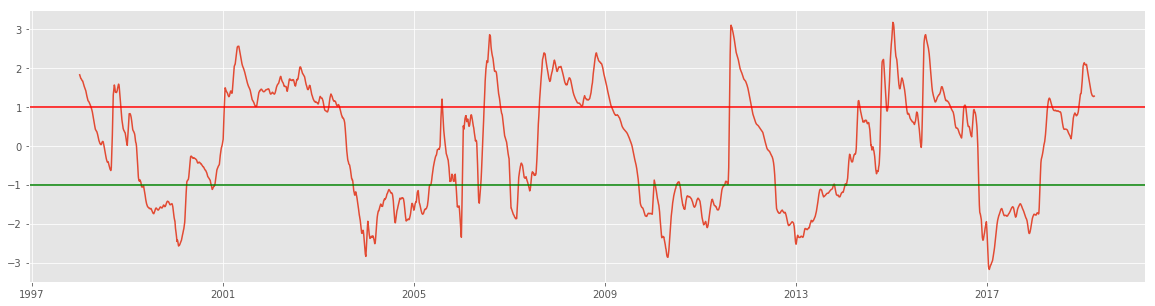

In [47]:
# 作圖
plt.figure(figsize=(20,5))
#plt.title()
plt.plot(z)
plt.axhline(-1,color='g')
plt.axhline(1,color='r')


plt.legend(loc = 2)
plt.show()

In [48]:
ma_turbulence.rank()

,ma_turbulence
1998-01-01,5685.0
1998-01-02,5488.0
1998-01-03,5495.0
1998-01-04,5475.0
1998-01-05,5452.0
1998-01-06,5454.0
1998-01-07,5462.0
1998-01-08,5453.0
1998-01-09,5433.0
1998-01-10,5440.0


In [49]:
z_score = z['Z_score']
risk_now=pd.concat([ma_turbulence,z_score,ma_turbulence.rank()],axis=1).dropna()
risk_now.columns=range(3)
x1=np.arange(0,3.1,0.1)
x2=np.arange(0,4.1,0.1)
x3=np.arange(0,5.1,0.1)
y1=3-x1*5
y2=4-x2*5
y3=5-x3*5

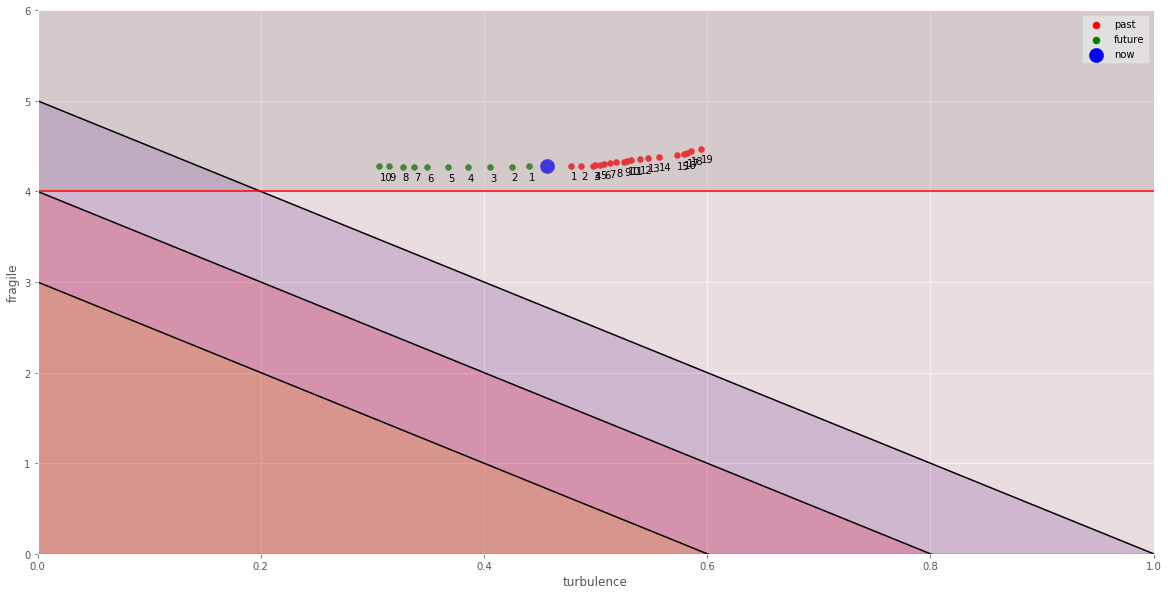

In [50]:
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
#ax1.scatter(((risk_now[0]-risk_now[0].min())/1000)[-20:-1],(risk_now[1]+3)[-20:-1],color='r',s=75,label='past')
#ax1.scatter(((risk_now[0]-risk_now[0].min())/1000)[-1],(risk_now[1]+3)[-1],color='b',s=200,label='now')
for i,type in enumerate(reversed(range(1,20))):
    x = ((risk_now[2]/risk_now[2].max()))[-30:-11][i]
    y = (risk_now[1]+3)[-30:-11][i]
    plt.scatter(x, y, color='red')
    plt.plot(x, y, color='r')
    plt.text(x,y-0.15,type, fontsize=10)
#plt.scatter(((risk_now[2]/risk_now[2].max()))[-30:-1],(risk_now[1]+3)[-30:-1],color='r',s=75,label='past')
plt.scatter(((risk_now[2]/risk_now[2].max()))[-11],(risk_now[1]+3)[-11],color='r',s=50,label='past')
plt.scatter(((risk_now[2]/risk_now[2].max()))[-11],(risk_now[1]+3)[-11],color='g',s=50,label='future')
plt.scatter(((risk_now[2]/risk_now[2].max()))[-11],(risk_now[1]+3)[-11],color='b',s=200,label='now')
for i,type in enumerate(reversed(range(1,11))):
    x = ((risk_now[2]/risk_now[2].max()))[-10:][i]
    y = (risk_now[1]+3)[-10:][i]
    plt.scatter(x, y, color='green')
    plt.plot(x, y, color='r')
    plt.text(x,y-0.15,11-type, fontsize=10)
#for i, txt in enumerate(range(29)):
#    ax1.annotate(txt,(((risk_now[2]/risk_now[2].max()))[-30:-1],(risk_now[1]+3)[-30:-1]))
plt.plot(x1,y1,x2,y2,x3,y3,color='black')
plt.fill_between(x1,0,y1, color='yellow', alpha='0.2')
plt.fill_between(x2,0,y2, color='red', alpha='0.2')
plt.fill_between(x3,0,y3, color='purple', alpha='0.2')
plt.fill_between(x3,y3,6, color='pink', alpha='0.2')
plt.fill_between(x3,4,6, color='grey', alpha='0.2')
plt.axhline(y=4, color='red', linestyle='-')
plt.xlim((0,1))
plt.ylim((0,6))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.xlabel('turbulence')
plt.ylabel('fragile')
plt.legend()
plt.show()

In [51]:
import Tkinter as tk
def show_ratio():
    global on_hit
    if on_hit == False:
        on_hit = True
        var.set(z_score[-10:])  
    else:      
        on_hit = False
        var.set('') 
window = tk.Tk()
window.title('AR_Ratio')
window.geometry('500x500')
var = tk.StringVar()  
l = tk.Label(window, 
    textvariable=var,   
    bg='white', font=('Arial', 20,), width=50, height=14)
l.pack() 
b = tk.Button(window, 
    text='show ratio',   
    width=15, height=2, 
    command=show_ratio)    
b.pack()  
on_hit = False 
window.mainloop()

In [52]:
import Tkinter as tk
def show_ratio():
    global on_hit
    if on_hit == False:
        on_hit = True
        var.set(z_score[-20:-10])  
    else:      
        on_hit = False
        var.set('') 
window = tk.Tk()
window.title('AR_Ratio')
window.geometry('500x500')
var = tk.StringVar()  
l = tk.Label(window, 
    textvariable=var,   
    bg='white', font=('Arial', 20,), width=50, height=14)
l.pack() 
b = tk.Button(window, 
    text='show ratio',   
    width=15, height=2, 
    command=show_ratio)    
b.pack()  
on_hit = False 
window.mainloop()

In [27]:
bond_price=pd.read_csv('C:\Users\Sascha683\work\data\SystematicCrisis\enhance/bond_price.csv' ,  index_col=0 ,header= 0, encoding = 'utf8', parse_dates = True)
agg=bond_price.iloc[:,0]
agg=agg.loc["1998-01-01":]

In [28]:
weight=pd.DataFrame(columns=["stock","bond"])
for i in range(agg.shape[0]):
    if z_score.iloc[i]>1:
        weight.loc[z_score.index[i]]=[0,1]
    elif z_score.iloc[i]<-1:
        weight.loc[z_score.index[i]]=[1,0]
    else:
        weight.loc[z_score.index[i]]=[0.5,0.5]

In [29]:
SPXT_price=SPXT_price/SPXT_price.iloc[0]
SPXT_return=(SPXT_price/SPXT_price.shift(1)).fillna(1)
#SPXT_return_adj=SPXT_return.sub(abs(weight-weight.shift(1)).sum(axis=1).fillna(0)*0.002,axis=0)
agg_return=agg/agg.shift(1)
asset_return=pd.concat([SPXT_return,agg_return],axis=1).fillna(1)
asset_return.columns=["stock","bond"]
asset_return_adjar=asset_return.sub(abs(weight-weight.shift(1)).sum(axis=1).fillna(0)*0.002,axis=0)

In [30]:
ar_return=(weight.shift(1)*asset_return_adjar).sum(axis=1).fillna(1)
ar_price=np.cumprod(ar_return)

In [31]:
ar_price=ar_price.loc["2000-01-01":]/ar_price.loc["2000-01-01":][0]
ar_return=ar_return.loc["2000-01-01":]
SPXT_return=SPXT_return.loc["2000-01-01":]
SPXT_price=SPXT_price.loc["2000-01-01":]/SPXT_price.loc["2000-01-01":][0]

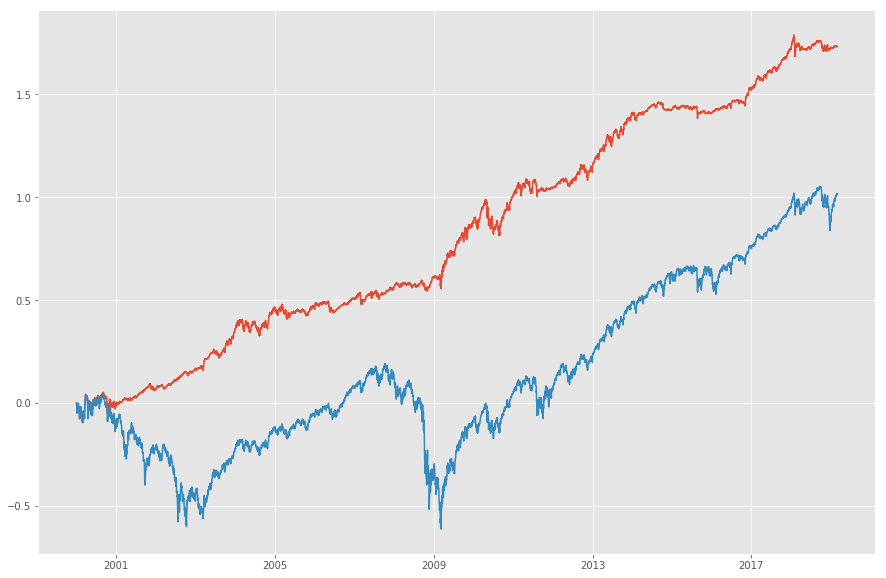

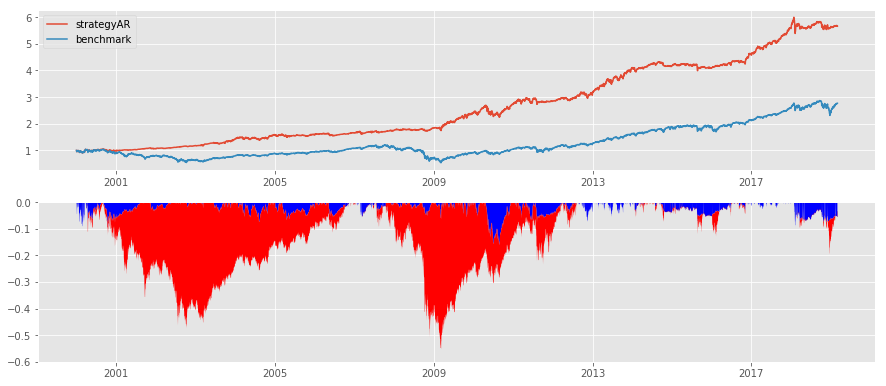

annual_r=0.094465501487850601
annual_ben=0.054497172845071384
annual_s=0.09541962679079355
bench_s=0.1908901924735463


In [32]:
time=ar_price.index
x=1
drawdown=0
for i in range(1,len(ar_price)):
    if ar_price[i]>x:
        x=ar_price[i]
    drawdown=np.append(drawdown,-(1-ar_price[i]/x))
drawdown_world=0
x=1
for i in range(1,len(SPXT_price)):
    if SPXT_price[i]>x:
        x=SPXT_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(ar_price))
plt.plot(time,np.log(SPXT_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax1.plot(time,ar_price,label='strategyAR')
ax1.plot(time,SPXT_price,label='benchmark')
ax1.legend()
drawdown_inv=[]
drawdown_world_inv=[]
for i in range(len(drawdown)):
    if drawdown[i]>=drawdown_world[i]:
        drawdown_inv.append(0)
        drawdown_world_inv.append(0)
    else:
        drawdown_inv.append(drawdown_world[i])
        drawdown_world_inv.append(drawdown[i])
        drawdown_world[i]=0
        drawdown[i]=0
ax2.fill_between(time,0,drawdown,facecolor='blue')
ax2.fill_between(time,drawdown_world_inv,drawdown_inv,facecolor='red')
ax2.fill_between(time,drawdown,drawdown_world,facecolor='red')
ax2.fill_between(time,0,drawdown_world_inv,facecolor='blue')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
plt.show()
annual_r=ar_price[-1]**(365.0/ar_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(365.0/SPXT_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=ar_return.std()*m.sqrt(365)
bench_s=SPXT_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

In [64]:
ar_price.to_excel("ar_price_nontrade.xlsx")

In [33]:
ar_price.loc["2019-01-01":]/ar_price.loc["2019-01-01":][0]#YTD看最後一項

2019-01-01    1.000000
2019-01-02    1.001275
2019-01-03    1.006811
2019-01-04    1.002135
2019-01-05    1.002135
2019-01-06    1.002135
2019-01-07    1.001852
2019-01-08    1.000601
2019-01-09    1.000640
2019-01-10    1.000059
2019-01-11    1.001774
2019-01-12    1.001774
2019-01-13    1.001774
2019-01-14    1.001202
2019-01-15    1.001226
2019-01-16    1.000909
2019-01-17    1.000689
2019-01-18    0.999878
2019-01-19    0.999878
2019-01-20    0.999878
2019-01-21    0.999878
2019-01-22    1.002575
2019-01-23    1.001857
2019-01-24    1.004285
2019-01-25    1.002834
2019-01-26    1.002834
2019-01-27    1.002834
2019-01-28    1.003503
2019-01-29    1.005345
2019-01-30    1.006631
                ...   
2019-02-03    1.008101
2019-02-04    1.006973
2019-02-05    1.008844
2019-02-06    1.008981
2019-02-07    1.010945
2019-02-08    1.011966
2019-02-09    1.011966
2019-02-10    1.011966
2019-02-11    1.010789
2019-02-12    1.010041
2019-02-13    1.009039
2019-02-14    1.011067
2019-02-15 

In [34]:
SPXT_price.loc["2019-01-01":]/SPXT_price.loc["2019-01-01":][0]

0
2019-01-01    1.000000
2019-01-02    1.001272
2019-01-03    0.976743
2019-01-04    1.010278
2019-01-05    1.010278
2019-01-06    1.010278
2019-01-07    1.017363
2019-01-08    1.027250
2019-01-09    1.031788
2019-01-10    1.036449
2019-01-11    1.036301
2019-01-12    1.036301
2019-01-13    1.036301
2019-01-14    1.030970
2019-01-15    1.042045
2019-01-16    1.044386
2019-01-17    1.052417
2019-01-18    1.066321
2019-01-19    1.066321
2019-01-20    1.066321
2019-01-21    1.066321
2019-01-22    1.051268
2019-01-23    1.053583
2019-01-24    1.055068
2019-01-25    1.064060
2019-01-26    1.064060
2019-01-27    1.064060
2019-01-28    1.055708
2019-01-29    1.054189
2019-01-30    1.070699
                ...   
2019-02-03    1.081250
2019-02-04    1.088596
2019-02-05    1.093732
2019-02-06    1.091404
2019-02-07    1.081351
2019-02-08    1.082440
2019-02-09    1.082440
2019-02-10    1.082440
2019-02-11    1.083219
2019-02-12    1.097259
2019-02-13    1.100668
2019-02-14    1.098132
2019-02-1

In [35]:
OECD_signal=pd.read_excel("Z:\Sascha683\OECD signal daily.xlsx",parse_dates=True)
weight_OECD=OECD_signal/1
weight_OECD.columns=["bond"]
weight_OECD["stock"]=1-weight_OECD
asset_return_adjoecd=asset_return.loc["1999-07-01":]
asset_return_adjoecd=asset_return_adjoecd.sub(abs(weight_OECD-weight_OECD.shift(1)).sum(axis=1)*0.002,axis=0)
OECD_allocation=(asset_return_adjoecd*weight_OECD.shift(1)).sum(axis=1).loc["1999-07-01":]
OECD_allocation_price=np.cumprod(OECD_allocation)
OECD_allocation_price=OECD_allocation_price.loc["2000-01-01":]/OECD_allocation_price.loc["2000-01-01":][0]
OECD_allocation=OECD_allocation.loc["2000-01-01":]

C:\Users\Sascha683\anaconda\lib\site-packages\pandas\io\excel.py:351: UserWarning: The 'parse_dates=True' keyword of read_excel was provided without an 'index_col' keyword value.
  warn("The 'parse_dates=True' keyword of read_excel was provided"


C:\Users\Sascha683\anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


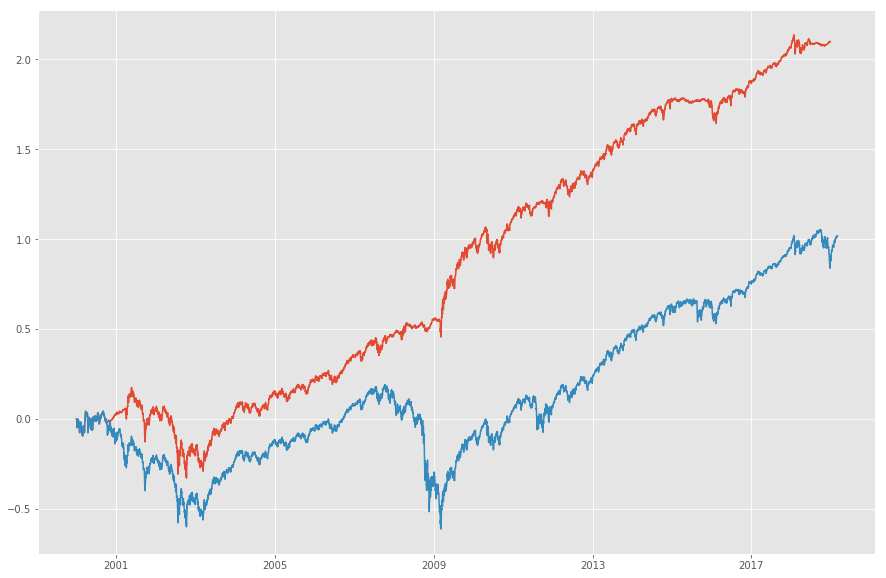

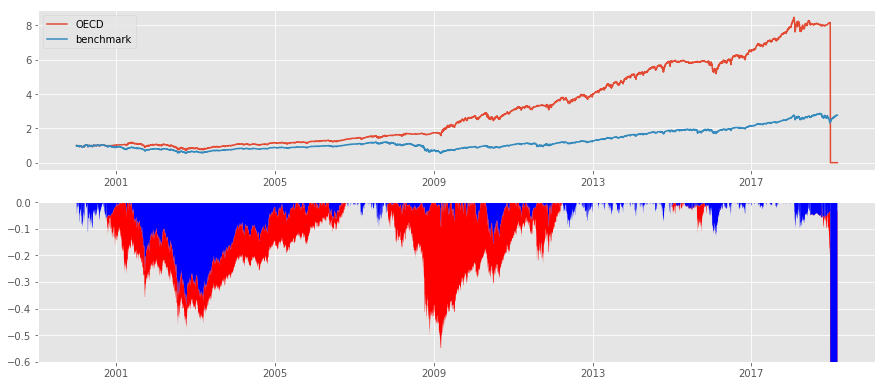

annual_r=-1.0
annual_ben=0.054497172845071384
annual_s=1.852500033317001
bench_s=0.1908901924735463


In [36]:
time=OECD_allocation_price.index
x=1
drawdown=0
for i in range(1,len(OECD_allocation_price)):
    if OECD_allocation_price[i]>x:
        x=OECD_allocation_price[i]
    drawdown=np.append(drawdown,-(1-OECD_allocation_price[i]/x))
drawdown_world=0
x=1
for i in range(1,len(SPXT_price)):
    if SPXT_price[i]>x:
        x=SPXT_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(OECD_allocation_price))
plt.plot(time,np.log(SPXT_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax1.plot(time,OECD_allocation_price,label='OECD')
ax1.plot(time,SPXT_price,label='benchmark')
ax1.legend()
drawdown_inv=[]
drawdown_world_inv=[]
for i in range(len(drawdown)):
    if drawdown[i]>=drawdown_world[i]:
        drawdown_inv.append(0)
        drawdown_world_inv.append(0)
    else:
        drawdown_inv.append(drawdown_world[i])
        drawdown_world_inv.append(drawdown[i])
        drawdown_world[i]=0
        drawdown[i]=0
ax2.fill_between(time,0,drawdown,facecolor='blue')
ax2.fill_between(time,drawdown_world_inv,drawdown_inv,facecolor='red')
ax2.fill_between(time,drawdown,drawdown_world,facecolor='red')
ax2.fill_between(time,0,drawdown_world_inv,facecolor='blue')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
plt.show()
annual_r=OECD_allocation_price[-1]**(365.0/OECD_allocation_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(365.0/SPXT_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=OECD_allocation.std()*m.sqrt(365)
bench_s=SPXT_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

In [37]:
totaldata=pd.read_excel("Z:\Sascha683\OECD&MOM.xlsx",parse_dates=True)
totaldata_return=(totaldata/totaldata.shift(1)).fillna(1)

In [41]:
ISM_price=totaldata.iloc[:,0].loc["2000-01-01":]/totaldata.iloc[:,0].loc["1999-12-01":][0]
MOM_price=totaldata.iloc[:,1].loc["2000-01-01":]/totaldata.iloc[:,1].loc["1999-12-01":][0]
OECD_price=totaldata.iloc[:,2].loc["2000-01-01":]/totaldata.iloc[:,2].loc["1999-12-01":][0]
ISM_return=totaldata_return.iloc[:,0].loc["2000-01-01":]
MOM_return=totaldata_return.iloc[:,1].loc["2000-01-01":]
OECD_return=totaldata_return.iloc[:,2].loc["2000-01-01":]
SPXT_month_price=SPXT_price.loc[ISM_price.index]
SPXT_month_return=(SPXT_price.loc[ISM_price.index]/SPXT_price.loc[ISM_price.index].shift(1)).fillna(SPXT_price.loc[ISM_price.index][0])
ar_month_price=ar_price.loc[ISM_price.index]
ar_month_return=(ar_price.loc[ISM_price.index]/ar_price.loc[ISM_price.index].shift(1)).fillna(ar_price.loc[ISM_price.index][0])

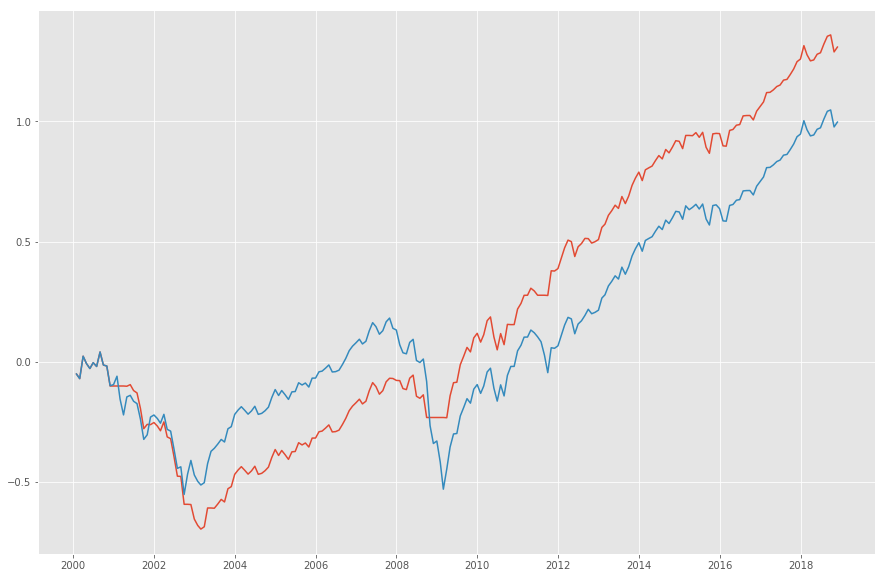

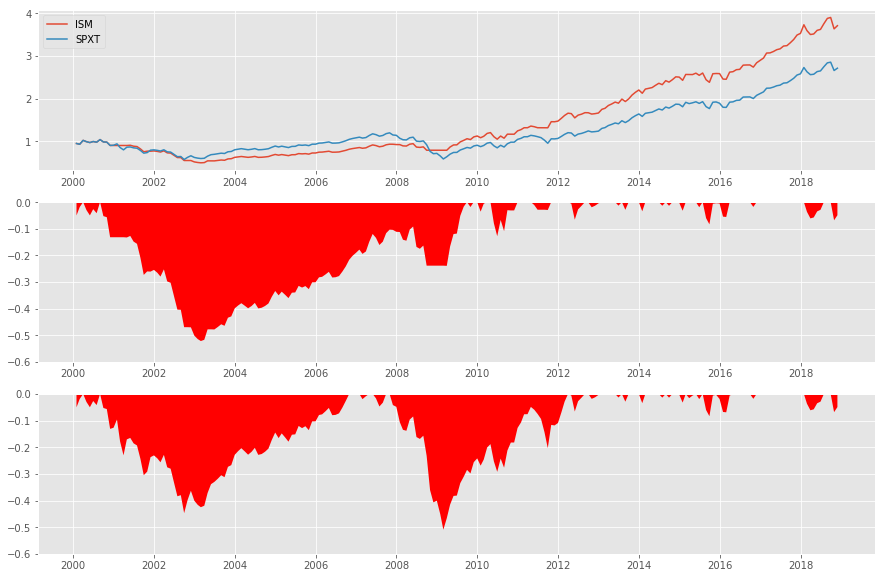

annual_r=0.071673346220277434
annual_ben=0.055115114863205861
annual_s=0.6629045013352405
bench_s=0.7945023315041679


In [42]:
time=ISM_price.index
x=ISM_price[0]
drawdown=ISM_price[0]-1
for i in range(1,len(ISM_price)):
    if ISM_price[i]>x:
        x=ISM_price[i]
    drawdown=np.append(drawdown,-(1-ISM_price[i]/x))
drawdown_world=SPXT_month_price[0]-1
x=SPXT_month_price[0]
for i in range(1,len(SPXT_month_price)):
    if SPXT_month_price[i]>x:
        x=SPXT_month_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_month_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(ISM_price))
plt.plot(time,np.log(SPXT_month_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(time,ISM_price,label='ISM')
ax1.plot(time,SPXT_month_price,label='SPXT')
ax1.legend()
ax2.fill_between(time,0,drawdown,facecolor='red')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
ax3.fill_between(time,0,drawdown_world,facecolor='red')
ax3.set_ylim(ymax = 0, ymin = -0.6)
ax3.legend()
plt.show()
annual_r=ISM_price[-1]**(12.0/ISM_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(12.0/SPXT_month_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=ISM_return.std()*m.sqrt(365)
bench_s=SPXT_month_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

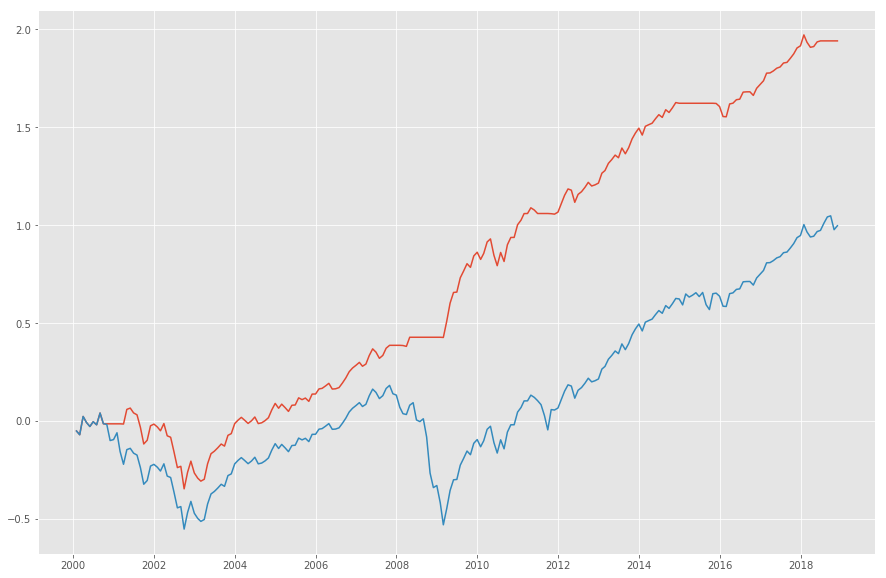

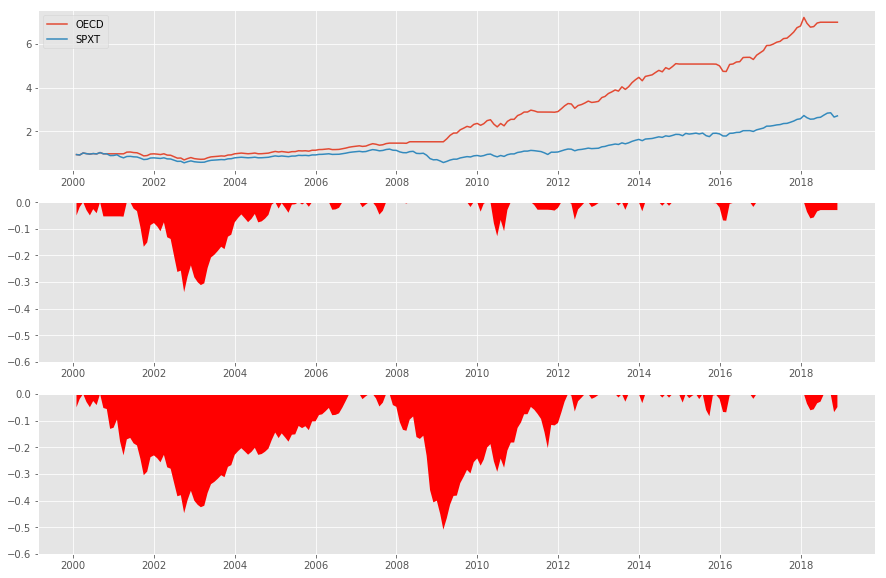

annual_r=0.10809053694783466
annual_ben=0.055115114863205861
annual_s=0.6224335530014076
bench_s=0.7945023315041679


In [43]:
time=OECD_price.index
x=OECD_price[0]
drawdown=OECD_price[0]-1
for i in range(1,len(OECD_price)):
    if OECD_price[i]>x:
        x=OECD_price[i]
    drawdown=np.append(drawdown,-(1-OECD_price[i]/x))
drawdown_world=SPXT_month_price[0]-1
x=SPXT_month_price[0]
for i in range(1,len(SPXT_month_price)):
    if SPXT_month_price[i]>x:
        x=SPXT_month_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_month_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(OECD_price))
plt.plot(time,np.log(SPXT_month_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(time,OECD_price,label='OECD')
ax1.plot(time,SPXT_month_price,label='SPXT')
ax1.legend()
ax2.fill_between(time,0,drawdown,facecolor='red')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
ax3.fill_between(time,0,drawdown_world,facecolor='red')
ax3.set_ylim(ymax = 0, ymin = -0.6)
ax3.legend()
plt.show()
annual_r=OECD_price[-1]**(12.0/OECD_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(12.0/SPXT_month_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=OECD_return.std()*m.sqrt(365)
bench_s=SPXT_month_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

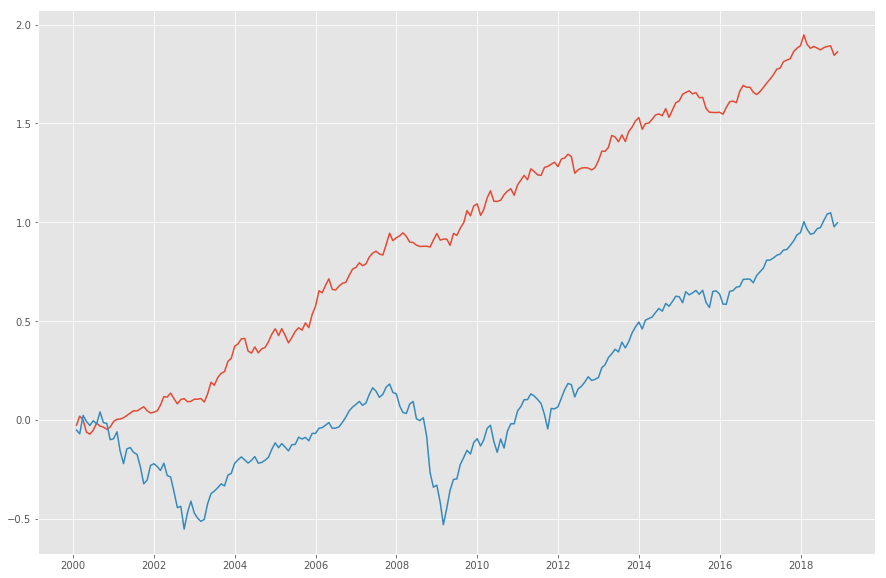

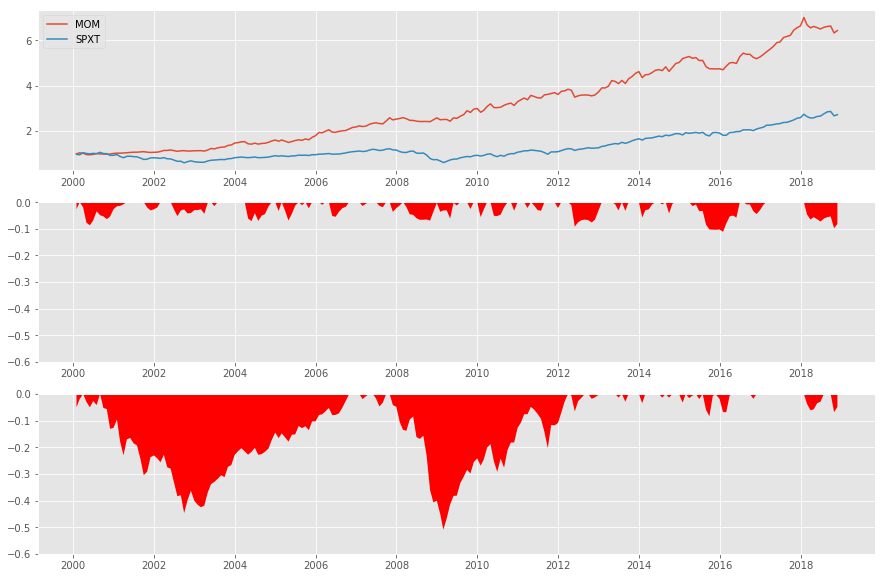

annual_r=0.10344555403164635
annual_ben=0.055115114863205861
annual_s=0.5321533323063389
bench_s=0.7945023315041679


In [44]:
time=MOM_price.index
x=MOM_price[0]
drawdown=MOM_price[0]-1
for i in range(1,len(MOM_price)):
    if MOM_price[i]>x:
        x=MOM_price[i]
    drawdown=np.append(drawdown,-(1-MOM_price[i]/x))
drawdown_world=SPXT_month_price[0]-1
x=SPXT_month_price[0]
for i in range(1,len(SPXT_month_price)):
    if SPXT_month_price[i]>x:
        x=SPXT_month_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_month_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(MOM_price))
plt.plot(time,np.log(SPXT_month_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(time,MOM_price,label='MOM')
ax1.plot(time,SPXT_month_price,label='SPXT')
ax1.legend()
ax2.fill_between(time,0,drawdown,facecolor='red')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
ax3.fill_between(time,0,drawdown_world,facecolor='red')
ax3.set_ylim(ymax = 0, ymin = -0.6)
ax3.legend()
plt.show()
annual_r=MOM_price[-1]**(12.0/MOM_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(12.0/SPXT_month_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=MOM_return.std()*m.sqrt(365)
bench_s=SPXT_month_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

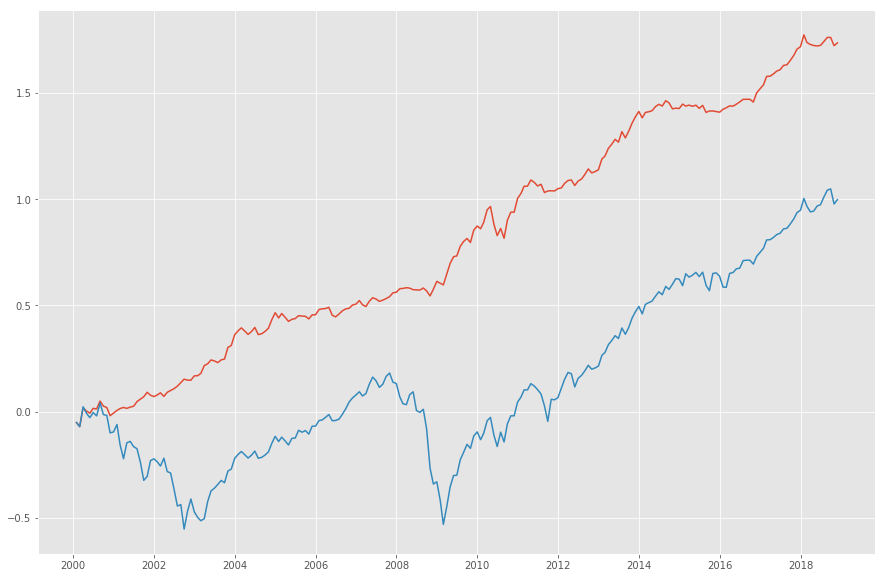

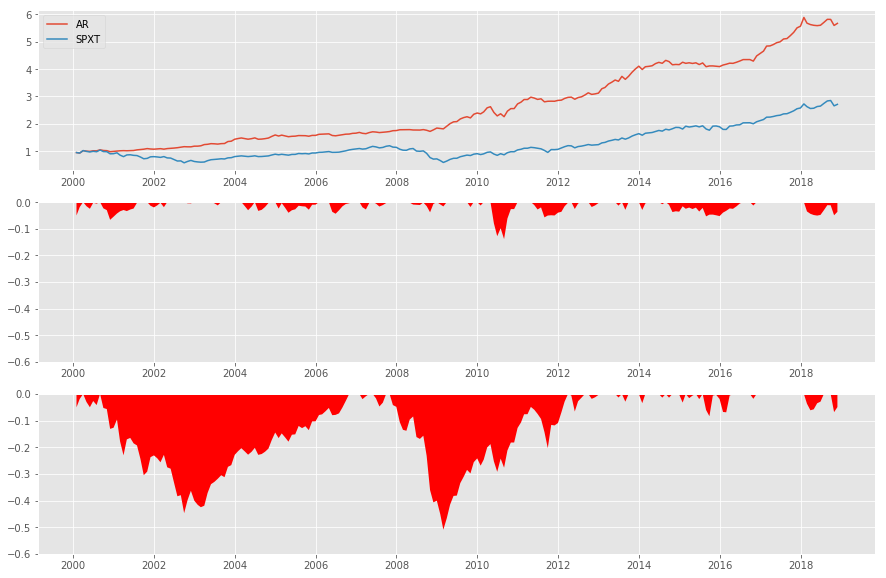

annual_r=0.096053233701859808
annual_ben=0.055115114863205861
annual_s=0.4358885852491958
bench_s=0.7945023315041679


In [45]:
time=ar_month_price.index
x=ar_month_price[0]
drawdown=ar_month_price[0]-1
for i in range(1,len(ar_month_price)):
    if ar_month_price[i]>x:
        x=ar_month_price[i]
    drawdown=np.append(drawdown,-(1-ar_month_price[i]/x))
drawdown_world=SPXT_month_price[0]-1
x=SPXT_month_price[0]
for i in range(1,len(SPXT_month_price)):
    if SPXT_month_price[i]>x:
        x=SPXT_month_price[i]
    drawdown_world=np.append(drawdown_world,-(1-SPXT_month_price[i]/x))
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(ar_month_price))
plt.plot(time,np.log(SPXT_month_price))
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(time,ar_month_price,label='AR')
ax1.plot(time,SPXT_month_price,label='SPXT')
ax1.legend()
ax2.fill_between(time,0,drawdown,facecolor='red')
ax2.set_ylim(ymax = 0, ymin = -0.6)
ax2.legend()
ax3.fill_between(time,0,drawdown_world,facecolor='red')
ax3.set_ylim(ymax = 0, ymin = -0.6)
ax3.legend()
plt.show()
annual_r=ar_month_price[-1]**(12.0/ar_month_price.shape[0])-1.0
print "annual_r="+ repr(annual_r)
annual_ben=SPXT_price[-1]**(12.0/SPXT_month_price.shape[0])-1.0
print "annual_ben="+ repr(annual_ben)
import math as m
annual_s=ar_month_return.std()*m.sqrt(365)
bench_s=SPXT_month_return.std()*m.sqrt(365)
print "annual_s="+ repr(annual_s)
print "bench_s="+ repr(bench_s)

In [46]:
ar_return=(weight.shift(1)*asset_return_adjar).sum(axis=1).fillna(1)
ar_price=np.cumprod(ar_return)
oecd_return=(weight_OECD.shift(1)*asset_return_adjoecd).sum(axis=1).fillna(1)[1:]
oecd_price=np.cumprod(oecd_return)
oecd_price=oecd_price.loc[totaldata.index[6:]]
for i in range(6):
    oecd_price.loc[totaldata.index[i]]=1
oecd_price=oecd_price.sort_index()
strategy=pd.concat([totaldata,(ar_price.loc["1999-01-01":]/ar_price.loc["1999-01-01":][0]).loc[totaldata.index]],axis=1)
strategy.columns=["ISM","MOM","OECD","AR"]
strategy["OECD"]=oecd_price

In [47]:
#strategy["MOM"]=MOM_twoasset
#strategy=strategy.fillna(1)

In [48]:
strategy=strategy[["MOM","OECD","AR"]]
strategy_mom=(strategy/strategy.shift(12))
strategy_sharp=strategy_mom/(pd.rolling_std(strategy,window=12))
#strategy_sharp=strategy_mom
strategy_sharp=strategy_sharp.loc["2001-01-01":]
weight_strategy2=strategy_sharp*((strategy_sharp>0)/1).div((strategy_sharp*((strategy_sharp>0)/1)).sum(axis=1),axis=0)
weight_strategy1=((strategy_sharp.rank(axis=1))>1)/2
strategy_return=(strategy/strategy.shift(1)).loc["2001-01-01":]
#weight_strategy["cash"]=1-weight_strategy.sum(axis=1)
#strategy_return_adj["cash"]=np.ones(strategy_return_adj.shape[0])
strategy_return_adj1=strategy_return.sub(abs(weight_strategy1-weight_strategy1.shift(1)).sum(axis=1)*0.002,axis=0)
strategy_return_adj2=strategy_return.sub(abs(weight_strategy2-weight_strategy2.shift(1)).sum(axis=1)*0.002,axis=0)
strategy_allocation1=(weight_strategy1.shift(1)*strategy_return_adj1).sum(axis=1)[1:]
strategy_allocation_price1=np.cumprod(strategy_allocation1)
strategy_allocation2=(weight_strategy2.shift(1)*strategy_return_adj2).sum(axis=1)[1:]
strategy_allocation_price2=np.cumprod(strategy_allocation2)

C:\Users\Sascha683\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()
  This is separate from the ipykernel package so we can avoid doing imports until


In [49]:
weight_strategy1.sum()

MOM      60.0
OECD     53.0
AR      102.0
dtype: float64

In [50]:
a=(np.cumprod(strategy_return["MOM"])[-1]**(12.0/strategy_return.shape[0])-1)*100
b=(np.cumprod(strategy_return["OECD"])[-1]**(12.0/strategy_return.shape[0])-1)*100
c=(np.cumprod(strategy_return["AR"])[-1]**(12.0/strategy_return.shape[0])-1)*100
print "MOM  "+str(a)
print "OECD  "+str(b)
print "AR  "+str(c)
print strategy_return.std()*365

MOM  11.0041920484
OECD  12.1829129776
AR  10.2102381358
MOM     10.116693
OECD    11.729136
AR       7.924645
dtype: float64


In [51]:
print (strategy_allocation_price1[-1]**(12.0/strategy_allocation_price1.shape[0])-1)*100
print strategy_allocation1.std()*365
print (strategy_allocation_price2[-1]**(12.0/strategy_allocation_price2.shape[0])-1)*100
print strategy_allocation2.std()*365

11.4217401083
7.92350881503
11.3033360621
8.01019357996


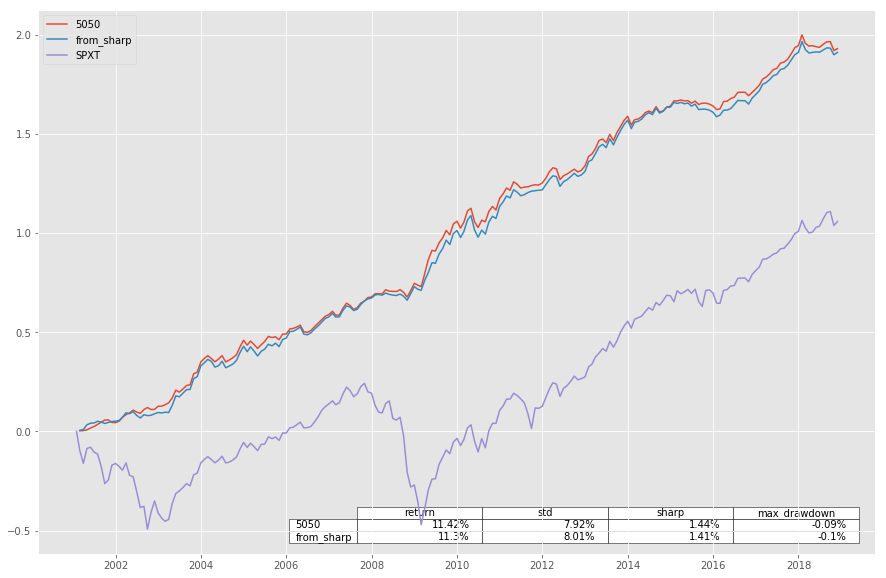

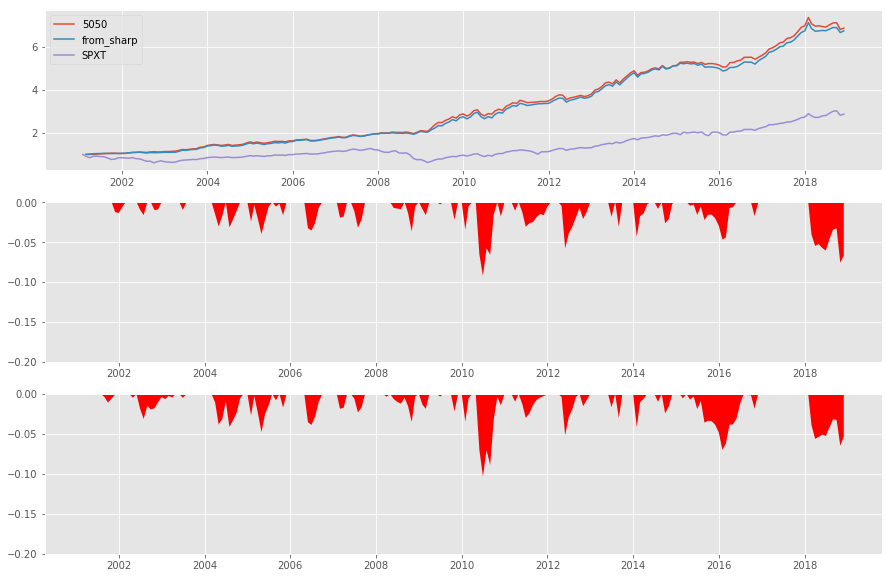

In [52]:
a=(strategy_allocation_price1[-1]**(12.0/strategy_allocation_price1.shape[0])-1)*100
b=strategy_allocation1.std()*365
c=a/b
e=(strategy_allocation_price2[-1]**(12.0/strategy_allocation_price2.shape[0])-1)*100
f=strategy_allocation2.std()*365
g=e/f
a='%s'%  (np.round(a,2))+'%'
b='%s'%  (np.round(b,2))+'%'
c='%s'%  (np.round(c,2))+'%'
e='%s'%  (np.round(e,2))+'%'
f='%s'%  (np.round(f,2))+'%'
g='%s'%  (np.round(g,2))+'%'
time=strategy_allocation1.index
x=strategy_allocation_price1[0]
drawdown1=strategy_allocation_price1[0]-1
for i in range(1,len(strategy_allocation_price1)):
    if strategy_allocation_price1[i]>x:
        x=strategy_allocation_price1[i]
    drawdown1=np.append(drawdown1,-(1-strategy_allocation_price1[i]/x))
x=strategy_allocation_price2[0]
drawdown2=strategy_allocation_price2[0]-1
for i in range(1,len(strategy_allocation_price2)):
    if strategy_allocation_price2[i]>x:
        x=strategy_allocation_price2[i]
    drawdown2=np.append(drawdown2,-(1-strategy_allocation_price2[i]/x))
h=pd.DataFrame(drawdown1).min().iloc[0]
i=pd.DataFrame(drawdown2).min().iloc[0]
h='%s'%  (np.round(h,2))+'%'
i='%s'%  (np.round(i,2))+'%'
fig = plt.figure(figsize=(15,10))
plt.plot(time,np.log(strategy_allocation_price1),label='5050')
plt.plot(time,np.log(strategy_allocation_price2),label='from_sharp')
plt.plot(SPXT_month_price.loc["2001-01-01":].index,np.log(SPXT_month_price.loc["2001-01-01":]/SPXT_month_price.loc["2001-01-01":][0]),label='SPXT')
plt.legend()
col_labels=['return','std','sharp','max_drawdown']
row_labels=['5050','from_sharp']
table_vals=[[a,b,c,h],[e,f,g,i]]
plt.table(cellText=table_vals,rowLabels=row_labels,colLabels=col_labels,loc='lower right',colWidths = [0.15]*4)
plt.show()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)
ax1.plot(time,strategy_allocation_price1,label='5050')
ax1.plot(time,strategy_allocation_price2,label='from_sharp')
ax1.plot(SPXT_month_price.loc["2001-01-01":].index,SPXT_month_price.loc["2001-01-01":]/SPXT_month_price.loc["2001-01-01":][0],label='SPXT')
#ax1.plot(time,MOM_twoasset[1:],label='MOM')
ax1.legend()
ax2.fill_between(time,0,drawdown1,facecolor='red')
ax2.set_ylim(ymax = 0, ymin = -0.2)
ax2.legend()
ax3.fill_between(time,0,drawdown2,facecolor='red')
ax3.set_ylim(ymax = 0, ymin = -0.2)
ax3.legend()
plt.show()

In [53]:
MOM_weighting_number=pd.read_csv("Z:\Sascha683/MOM_weighting_all.csv",index_col=0,parse_dates=True)

In [54]:
MOM_weighting_number=MOM_weighting_number.div(MOM_weighting_number.sum(axis=1),axis=0)

In [55]:
MOM_weighting_number["bond"]=1-MOM_weighting_number["stock"]

In [56]:
MOM_weighting_number=MOM_weighting_number.iloc[:,0:2]
for i in range(MOM_weighting_number.shape[0]):
    if MOM_weighting_number.iloc[i,0]>=0.5:
        MOM_weighting_number.iloc[i,:]=[1,0]
    else:
        MOM_weighting_number.iloc[i,:]=[0,1]

In [57]:
asset_return_month=pd.DataFrame(columns=["stock","bond"])
for i in range(MOM_weighting_number.shape[0]-1):
    asset_return_month.loc[MOM_weighting_number.index[i+1]]=asset_return.loc[MOM_weighting_number.index[i]:MOM_weighting_number.index[i+1]].iloc[1:,:].cumprod().iloc[-1,:]

In [58]:
MOM_twoasset=(MOM_weighting_number.shift(1)*asset_return_month).fillna(0.5).sum(axis=1).cumprod()

In [59]:
MOM_twoasset

1999-06-30    1.000000
1999-07-31    0.968776
1999-08-31    0.963986
1999-09-30    0.937558
1999-10-31    0.996888
1999-11-30    1.017152
1999-12-31    1.077058
2000-01-31    1.022944
2000-02-29    1.003581
2000-03-31    1.101759
2000-04-30    1.068612
2000-05-31    1.046686
2000-06-30    1.072491
2000-07-31    1.082227
2000-08-31    1.149448
2000-09-30    1.088765
2000-10-31    1.095969
2000-11-30    1.113889
2000-12-31    1.134552
2001-01-31    1.153107
2001-02-28    1.163152
2001-03-31    1.168991
2001-04-30    1.164139
2001-05-31    1.171161
2001-06-30    1.142653
2001-07-31    1.168200
2001-08-31    1.181577
2001-09-30    1.195346
2001-10-31    1.220359
2001-11-30    1.203534
                ...   
2016-06-30    4.874149
2016-07-31    4.904966
2016-08-31    4.911857
2016-09-30    4.912774
2016-10-31    4.823163
2016-11-30    5.001790
2016-12-31    5.100652
2017-01-31    5.197392
2017-02-28    5.403771
2017-03-31    5.410065
2017-04-30    5.465629
2017-05-31    5.542545
2017-06-30 